## Logistic regression  in Theano

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import theano
import theano.tensor as T

### 'hello world' in Theano

In [2]:
# x is input placeholder
x = T.dmatrix('x')
# symbolic expression for logistic function
s = 1 / (1 + T.exp(-x))
# register s as a function of x
logistic = theano.function([x], s)

# call function (substitute value of x_input for x)
x_input = [[0, 1], [-1, -2]]
logistic(x_input)

array([[ 0.5       ,  0.73105858],
       [ 0.26894142,  0.11920292]])

### The model itself

The model uses regularization with $l_1$ and $l_2$ penalty, and is trained with gradient descent.

In [3]:
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score 


class LogisticRegression:
    
  
  def __init__(self,
               n_iter,
               batch_size=1000,
               lmbda=0.0001,
               l1_ratio=0,
               learning_rate=0.001,
               random_state=0):
    self.n_iter = n_iter
    self.l1_ratio = l1_ratio
    self.lmbda = lmbda
    self.learning_rate = learning_rate 
    self.batch_size = batch_size 
    
    np.random.seed(random_state)
   
    self.is_fitted = False
  
  def fit(self, X, y):
    if self.batch_size:
      n_examples = self.batch_size
    else:
      n_examples = X.shape[0]
    
    n_dim = X.shape[1]
    n_classes = len(np.unique(y))
    
    # inputs
    self.thX = T.dmatrix('thX')
    self.thy = T.vector('thy', dtype='int64')
    
    # weights
    self.thW, self.thB = self.__initialized_weights(n_dim, n_classes)
    
    # calculate probability and loss 
    Z = T.dot(self.thX, self.thW) + self.thB
    self.p_y_by_x = T.nnet.softmax(Z)
    # negative log likelihood
    ll = (T.log(self.p_y_by_x)
          [T.arange(n_examples), self.thy]) 
    nll = - T.mean(ll)
      
    regularization = self.__regularization(self.thW, self.lmbda, self.l1_ratio)
    
    self.loss = nll + regularization
    
    updates = self.__updates(
      self.loss,
      self.thW,
      self.thB,
      self.learning_rate)
   
    # setup training
    self.train_model = theano.function(
      inputs=[self.thX, self.thy],
      outputs=self.loss,
      updates=updates)
    
    self.__iter_training(self.train_model, X, y, self.n_iter, self.batch_size)
 

  def predict(self, X):
    if self.is_fitted:
      return self.__prediction_function()(X)
    else:
      raise NotFittedError

      
  def score(self, X, y):
    y_pred = self.predict(X)
    return accuracy_score(y, y_pred)
      
       
  def __initialized_weights(self, n_dim, n_classes):
    """
    initialize weights (shared variables)
    """
    
    # initialize class weights
    thW = theano.shared(
        value=np.zeros(
          (n_dim, n_classes),
          dtype=theano.config.floatX),
        name='thW',
        borrow=True)

    # initialize the biases b as a vector of n_out 0s
    thB = theano.shared(
      value=np.zeros(
        (n_classes,),
        dtype=theano.config.floatX),
      name='thB',
      borrow=True)
    return thW, thB
       
    
  def __prediction_function(self):
    """
    actual function used for predicting y given X
    """
    y_pred = T.argmax(self.p_y_by_x, axis=1)
    return theano.function(
      inputs=[self.thX],
      outputs=y_pred)
  
  
  def __regularization(self, W, lmbda, l1_ratio):
    """
    regularization with l1 and l2 weight penalties
    """
    weight_penalty = T.sum(W ** 2)
    l1_penalty = T.sum(abs(W))
    return  (lmbda * 
              ((1 - l1_ratio) * weight_penalty +
               l1_ratio * l1_penalty))
  
  
  def __updates(self, loss, W, B, learning_rate):
    """
    gradient descent updates
    """
    
    # gradients
    gW = T.grad(cost=loss, wrt=W)
    gB = T.grad(cost=loss, wrt=B)
      
    updates = [
      (W, W - learning_rate * gW),
      (B, B - learning_rate * gB)]
    return updates
  
  
  def __iter_training(self, train_model, X, y, n_iter, batch_size):
    """
    iterate weight updates n_iter times and store loss for each step
    """ 
    def get_batch(batch_size):
      if batch_size:
        indices = np.random.choice(X.shape[0], batch_size, replace=False)
        return X[indices, :], y[indices] 
      else:
        return X, y
      
    self.losses = []
    for __ in range(n_iter):
      X_batch, y_batch = get_batch(batch_size)
      current_loss = train_model(X_batch, y_batch)
      self.losses.append(current_loss)
    
    self.losses = np.array(self.losses)
  
    self.is_fitted = True

## Training on MNIST 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

X = mnist['data']
y = mnist['target'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=0) 

In [5]:
from sklearn.preprocessing import StandardScaler

sscaler = StandardScaler()
X_train = sscaler.fit_transform(X_train)
X_test = sscaler.transform(X_test)

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [6]:
lreg = LogisticRegression(
  n_iter=500,
  batch_size=None,
  lmbda=0.001,
  l1_ratio=0.5,
  learning_rate=0.25)

In [7]:
%time lreg.fit(X_train, y_train)

CPU times: user 2min 56s, sys: 1.08 s, total: 2min 57s
Wall time: 1min 31s


Final loss: 0.3604


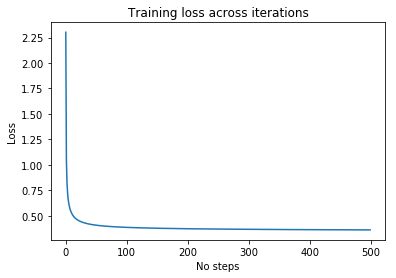

In [8]:
plt.plot(lreg.losses)
plt.title('Training loss across iterations')
plt.xlabel('No steps')
plt.ylabel('Loss')
print('Final loss: {:.4f}'.format(lreg.losses[-1]))
plt.show()

In [9]:
from sklearn.metrics import classification_report, accuracy_score 

y_pred = lreg.predict(X_test)
print('accuracy: {:.4f}'.format(lreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

accuracy: 0.9179
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      2761
          1       0.93      0.97      0.95      3151
          2       0.92      0.90      0.91      2796
          3       0.91      0.89      0.90      2856
          4       0.91      0.94      0.92      2730
          5       0.89      0.87      0.88      2525
          6       0.93      0.96      0.95      2751
          7       0.93      0.93      0.93      2917
          8       0.90      0.86      0.88      2730
          9       0.90      0.89      0.89      2783

avg / total       0.92      0.92      0.92     28000



## Logistic regression with Stochastic Gradient Descent

In [10]:
sgd_lreg = LogisticRegression(
  n_iter=500,
  batch_size=1000,
  lmbda=0.001,
  l1_ratio=0.5,
  learning_rate=0.25)

%time sgd_lreg.fit(X_train, y_train)

CPU times: user 8.64 s, sys: 92 ms, total: 8.74 s
Wall time: 4.59 s


Final loss: 0.3354
Final loss, smoothed: 0.3526


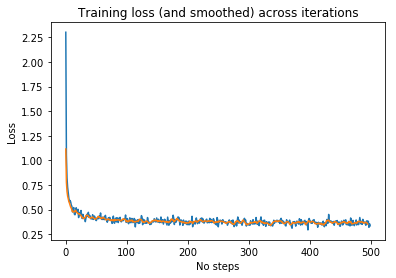

In [11]:
ma_width = 5
smoothed_sgd_loss = np.convolve(
  sgd_lreg.losses,
  v = np.ones(ma_width) / ma_width,
  mode='valid')

plt.plot(sgd_lreg.losses)
plt.plot(smoothed_sgd_loss)
plt.title('Training loss (and smoothed) across iterations')
plt.xlabel('No steps')
plt.ylabel('Loss')
print('Final loss: {:.4f}'.format(sgd_lreg.losses[-1]))
print('Final loss, smoothed: {:.4f}'.format(smoothed_sgd_loss[-1]))
plt.show()

In [12]:
y_pred = sgd_lreg.predict(X_test)
print('accuracy: {:.4f}'.format(sgd_lreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

accuracy: 0.9171
             precision    recall  f1-score   support

          0       0.95      0.96      0.96      2761
          1       0.93      0.97      0.95      3151
          2       0.92      0.90      0.91      2796
          3       0.91      0.89      0.90      2856
          4       0.91      0.93      0.92      2730
          5       0.89      0.87      0.88      2525
          6       0.94      0.96      0.95      2751
          7       0.93      0.93      0.93      2917
          8       0.90      0.86      0.88      2730
          9       0.89      0.89      0.89      2783

avg / total       0.92      0.92      0.92     28000



## Visualizing weights

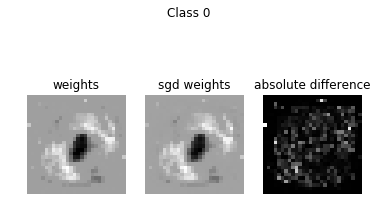

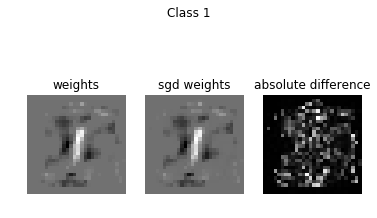

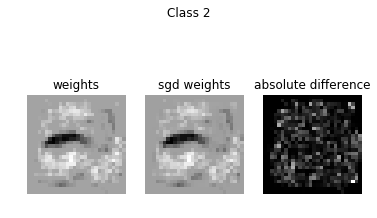

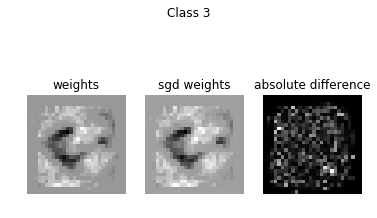

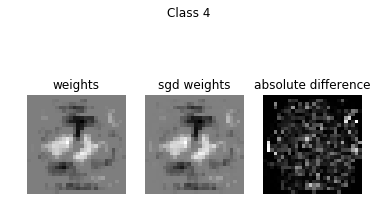

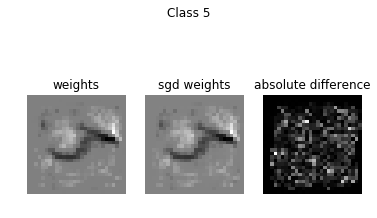

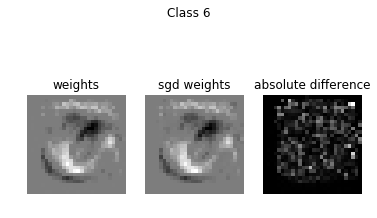

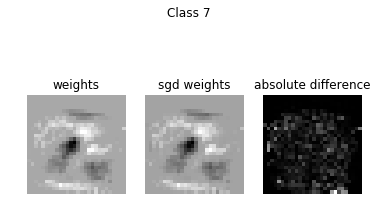

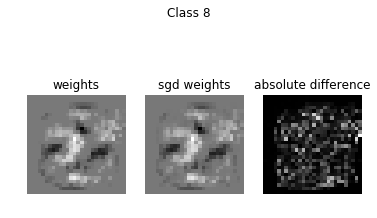

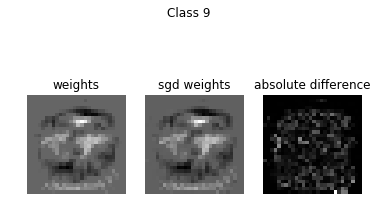

In [13]:
b = lreg.thB.get_value()

for i in range(10):
  digit_weights = lreg.thW.get_value().T[i, :].reshape(28, 28)
  sgd_digit_weights = sgd_lreg.thW.get_value().T[i, :].reshape(28, 28)
  f, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
  f.suptitle('Class {}'.format(i)) 
  
  
  ax1.imshow(digit_weights , cmap='gray')
  ax1.set_title('weights')
  ax1.axis('off') 
  
  ax2.imshow(sgd_digit_weights, cmap='gray')
  ax2.set_title('sgd weights')
  ax2.axis('off') 
  
  ax3.imshow(abs(digit_weights - sgd_digit_weights), cmap='gray')
  ax3.set_title('absolute difference'.format(str(i)))
  ax3.axis('off') 
  plt.show()